In [1]:

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import tree
import graphviz
from datetime import datetime
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from xgboost import plot_tree
from sklearn import preprocessing
%matplotlib inline
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 30,20
rcParams['font.size'] = 12

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

#### Data

通过 variance_5过滤掉 关机的数据     


In [2]:
train = pd.read_pickle(r'/home/wrj/FeatureDT/model/data/temp_train.pkl')
test = pd.read_pickle(r'/home/wrj/FeatureDT/model/data/temp_test.pkl')
target = 'label'
indicators = [x for x in train.columns if x != target]
X_train = train[indicators]
X_test = test[indicators]
y_train = train[target]
y_test = test[target]

In [3]:
X_train =  X_train.loc[X_train['variance_5']>0].reset_index(drop=False)
update_train_index = X_train['index']
y_train = y_train[update_train_index]
X_train.drop(['index'],axis=1,inplace=True)

In [4]:
X_test = X_test.loc[X_test['variance_5']>0].reset_index(drop=False)
update_test_index = X_test['index']
y_test = y_test[update_test_index]
X_test.drop(['index'],axis=1,inplace=True)

In [10]:
%%time
# 训练模型
model = xgb.XGBClassifier(max_depth=8, 
                          booster='gbtree',
                          num_class=5,
                          objective='multi:softmax',
                          gamma=0.2,
                          subsample=0.6,
                          colsample_bytree=0.6,
                          learning_rate=0.1, 
                          n_estimators=1000, 
                          silent=1,
                          nthread = 40
                          )
model.fit(X_train, y_train)


CPU times: user 1h 13min 48s, sys: 4.74 s, total: 1h 13min 53s
Wall time: 1min 59s


In [11]:
%%time
y_train_pre = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:,:]
print("训练集准确率: %s"  %metrics.accuracy_score(y_train_pre,y_train))

y_test_pre = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:,:]
print("测试集准确率: %s"  %metrics.accuracy_score(y_test_pre,y_test))


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


训练集准确率: 0.9990988609602538


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


测试集准确率: 0.9687277263007841
CPU times: user 50.7 s, sys: 88 ms, total: 50.8 s
Wall time: 50.8 s


#### confusion matrix

Confusion matrix, without normalization
[[ 9056     0    23     0   171]
 [    0  5280     0    29     8]
 [   23     0  9299   860     4]
 [    0     8   148 13088    23]
 [  184    16    84   174 17642]]


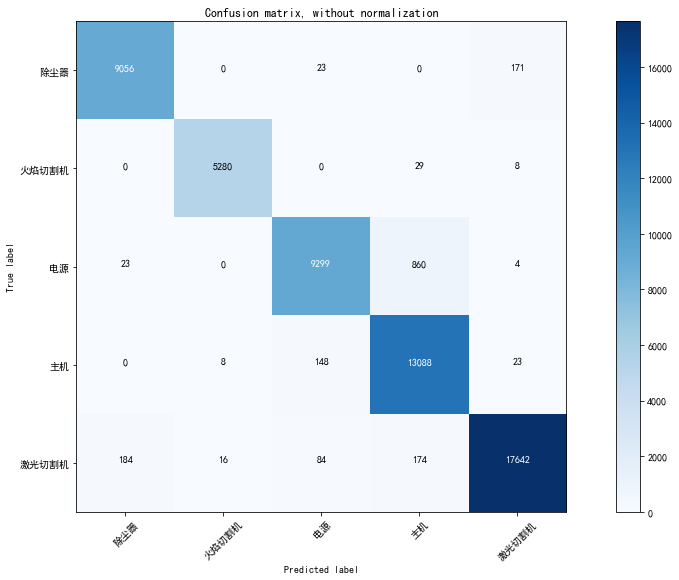

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
class_names = ['除尘器', '火焰切割机', '电源',  '主机', '激光切割机']
cnf_matrix = confusion_matrix(y_test, y_test_pre) 

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(14,8))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()